## Data Source:

https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data

https://imerit.net/blog/17-best-text-classification-datasets-for-machine-learning-all-pbm/ 



In [ ]:
from google.colab import drive #data source from https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#dependencies
import pandas as pd #for dataframe
import numpy as np
import spacy #text processing
import nltk #text processing 
from nltk.tokenize import WhitespaceTokenizer
import re # importing regex module
from sklearn.model_selection import train_test_split
import gensim
import keras
from wordcloud import WordCloud 
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

nlp = spacy.load('en', parse = False, tag=False, entity=False)
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load data
data = pd.read_csv('/content/gdrive/MyDrive/labeled_data.csv') #download and upload the csv data into your google drive.
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
# calling describe method
desc = data.describe(percentiles=None, include=None, exclude=None, datetime_is_numeric=False)
desc 

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


This **Data describe** *above* generates descriptive statistics.

Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

Analyzes both numeric and object series, as well as DataFrame column sets of mixed data types. The output will vary depending on what is provided. 

### Text preprocessing

Text preprocessing is a method to clean the text data and make it ready to feed data to the model. Text data contains noise in various forms like emotions, punctuation, text in a different case.



In [ ]:
def clean_text(text):

  text = text.lower()

  # remove links
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  # remove RT
  text = re.sub(r'rt[\s]+', '', text)
  # remove \n
  text = text.replace('\n', ' ')
  # remove user mentions
  text = re.sub(r'@[\w]*', '', text)
  # remove special characters
  text = re.sub('[^a-zA-Z0-9\s]', '', text)
  # remove punctuation
  text = re.sub('[.!,:;?]', '', text)
  # tokenize tweets
  text = WhitespaceTokenizer().tokenize(text)
  # remove stop word
  text = [w for w in text if not w in stopword_list]
  text = ' '.join(text)

  return text

In [ ]:
data['clean_text'] = data['tweet'].apply(clean_text)
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_text
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house amp man...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe 1st p...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch stato cry confused shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya...
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,yous muthafin lie 8220 right tl trash 8230 min...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",youve gone broke wrong heababy drove redneck c...
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


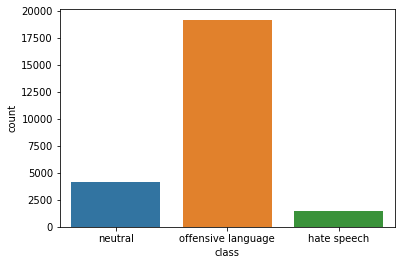

In [ ]:
fig = sns.countplot(data['class'].replace({0:'hate speech', 1:'offensive language', 2:'neutral'}))

**Imbalanced data:**
From the exploratory data anaysis (EDA) of our dataset in the above chart, the data, we notice that the percentage class distribution of the  dataset or ratio is; Offensive language 80%, hate speech 5%, neutral 15%. This means our dataset is imbalanced which implies that our result might be skewed. 

There are several approaches to resolving an imbalaned dataset as explained here https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html, which I shall factor.


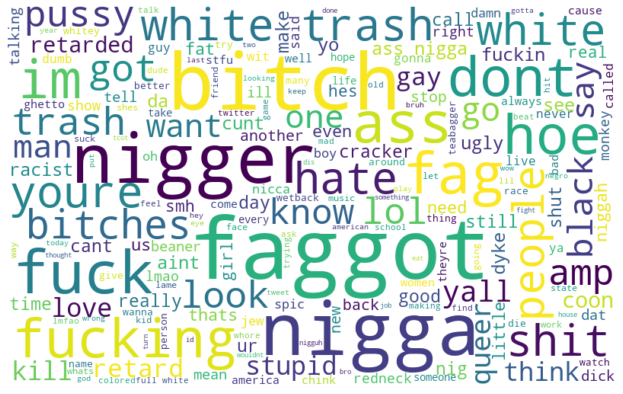

In [ ]:
# Word cloud for hate speech
all_words = ' '.join([text for text in data[data['class']==0]['clean_text']])
wordcloud = WordCloud(width=800, height=500, background_color='white',random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(40, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

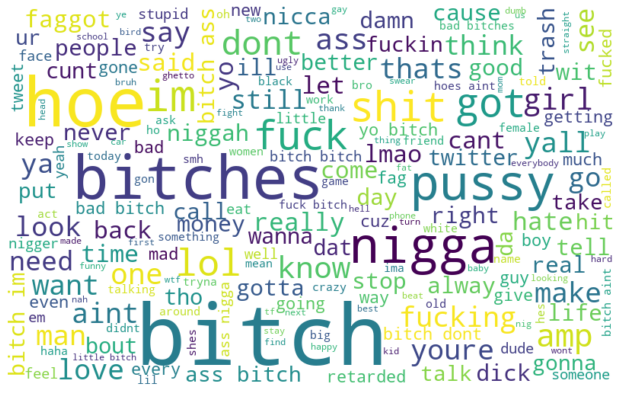

In [ ]:
# Word cloud for offensive language
all_words = ' '.join([text for text in data[data['class']==1]['clean_text']])
wordcloud = WordCloud(width=800, height=500, background_color='white',random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(40, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

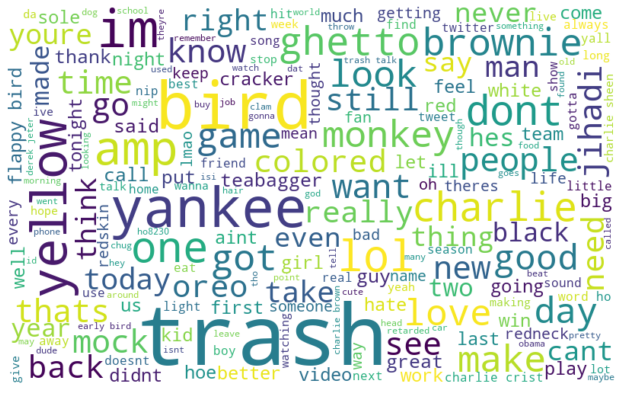

In [ ]:
# Word cloud for neutral tweets
all_words = ' '.join([text for text in data[data['class']==2]['clean_text']])
wordcloud = WordCloud(width=800, height=500, background_color='white',random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(40, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
data_new = data[['clean_text', 'class']] #preparation of text data for training
X = data_new['clean_text']
y = data_new['class']

In [ ]:
 text_train, text_test, class_train, class_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
le = LabelEncoder()
num_classes=3 

# tokenize train text & encode train labels
tokenized_train = [WhitespaceTokenizer().tokenize(text) for text in text_train]
y_train = le.fit_transform(class_train)
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)

# tokenize test text & encode test labels
tokenized_test = [WhitespaceTokenizer().tokenize(text) for text in text_test]
y_test = le.fit_transform(class_test)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

#### Text vectorization

Text Vectorization is the process of converting text into numerical representation. Here is some popular methods to accomplish text vectorization:


*   Binary Term Frequency
*   Bag of Words (BoW) Term Frequency
*   (L1) Normalized Term Frequency
*   (L2) Normalized TF-IDF
*   Word2Vec

This project uses **Word2Vec**




In [ ]:
# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3)

In [ ]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
                    
    return np.array(features)

In [ ]:
# generate averaged word vector features from word2vec model
word2vec_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=500)
word2vec_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# ANN model architecture
def construct_ann_architecture(num_input_features, num_labels):
    ann_model = Sequential()
    ann_model.add(Dense(512, activation='relu', input_shape=(num_input_features,)))
    ann_model.add(Dropout(0.2))
    ann_model.add(Dense(512, activation='relu'))
    ann_model.add(Dropout(0.2))
    ann_model.add(Dense(512, activation='relu'))
    ann_model.add(Dropout(0.2))
    ann_model.add(Dense(num_labels))
    ann_model.add(Activation('softmax'))

    ann_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return ann_model

In [ ]:
ann_model = construct_ann_architecture(num_input_features=500, num_labels=3)

In [ ]:
#epochs number of time we need to pass the data into the neural network for training
batch_size = 100
ann_model.fit(word2vec_train_features, y_train, epochs=50, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/50
157/157 [==============================] - 3s 18ms/step - loss: 0.6665 - accuracy: 0.7703 - val_loss: 0.6161 - val_accuracy: 0.7844
Epoch 2/50
157/157 [==============================] - 3s 16ms/step - loss: 0.6182 - accuracy: 0.7764 - val_loss: 0.5352 - val_accuracy: 0.7896
Epoch 3/50
157/157 [==============================] - 3s 16ms/step - loss: 0.5345 - accuracy: 0.8052 - val_loss: 0.5628 - val_accuracy: 0.7867
Epoch 4/50
157/157 [==============================] - 3s 16ms/step - loss: 0.5269 - accuracy: 0.8114 - val_loss: 0.5243 - val_accuracy: 0.8202
Epoch 5/50
157/157 [==============================] - 3s 16ms/step - loss: 0.5274 - accuracy: 0.8027 - val_loss: 0.4510 - val_accuracy: 0.8213
Epoch 6/50
157/157 [==============================] - 3s 16ms/step - loss: 0.5149 - accuracy: 0.8105 - val_loss: 0.4810 - val_accuracy: 0.8213
Epoch 7/50
157/157 [==============================] - 2s 16ms/step - loss: 0.5023 - accuracy: 0.8159 - val_loss: 0.4701 - val_accuracy: 0.8398

## Model evaluation

In [ ]:
y_pred = np.argmax(ann_model.predict(word2vec_test_features), axis=-1) #Argmax is most commonly used...
#in machine learning for finding the class with the largest predicted probability.
predictions = le.inverse_transform(y_pred)

In [ ]:
print(classification_report(class_test, predictions, target_names=['hate speech', 'offensive language', 'neither']))

                    precision    recall  f1-score   support

       hate speech       0.00      0.00      0.00       427
offensive language       0.87      0.96      0.91      5747
           neither       0.67      0.59      0.63      1261

          accuracy                           0.84      7435
         macro avg       0.51      0.52      0.51      7435
      weighted avg       0.79      0.84      0.81      7435



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
